In [14]:
import rasterio
from rasterio.plot import show
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.ndimage import gaussian_filter
import math
import cv2
import plotly.figure_factory as ff

In [15]:
cmap = 'nipy_spectral'
pi=math.pi

/opt/homebrew/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.

/var/folders/mg/_6sdzpzn5lx13z92xsyjwm280000gn/T/ipykernel_31545/3646042183.py:12: RuntimeWarning:

divide by zero encountered in divide

/var/folders/mg/_6sdzpzn5lx13z92xsyjwm280000gn/T/ipykernel_31545/3646042183.py:13: RuntimeWarning:

divide by zero encountered in divide



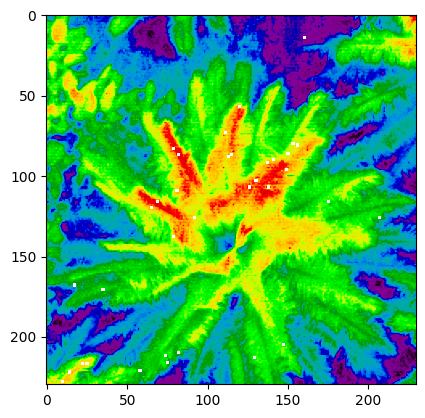

<Axes: >

In [16]:
with rasterio.open('./img/cropped/red.tif') as src:
    red=src.read(1)
with rasterio.open('./img/cropped/nir.tif') as src:
    nir = src.read(1)

with rasterio.open('./img/2. IMG_700101_000458_0092_NIR.TIF') as src:
    nir_field = src.read(1)

with rasterio.open('img/3. IMG_700101_000458_0092_RED.TIF') as src:
    red_field = src.read(1)

ndvi =(nir.astype(float)-red.astype(float)/(nir+red))
ndvi_field =(nir_field.astype(float)-red_field.astype(float)/(nir_field+red_field))
show(ndvi, cmap=cmap)

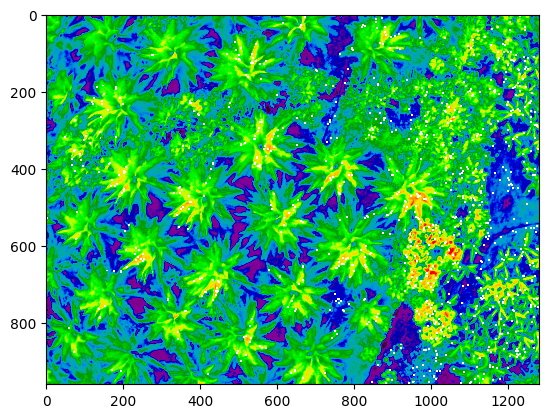

<Axes: >

In [17]:
show(ndvi_field, cmap=cmap)

In [18]:
print(red)

[[14016 12800 11008 ... 13440 13312 13376]
 [13824 11968 12288 ... 14848 14592 15360]
 [12800 13312 12544 ... 19776 19072 17600]
 ...
 [15360 15360 15488 ... 20288 22464 23360]
 [16000 15616 14976 ... 22272 20608 21376]
 [14400 14272 15040 ... 21632 19456 17600]]


In [19]:
red = red/65535.0
nir = nir/65535.0

In [20]:
red_values = [np.mean(red[idx][idx]) for idx in range(len(red))]
fig = ff.create_distplot([red_values], group_labels=["R"], colors=["red"], bin_size=0.001)
fig.layout.update(showlegend=True, template="simple_white")
fig.layout.update(title_text="Distribution of red channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.1
fig

I have this two images. This one corresponds to the RED band of a multispectral image: https://ibb.co/mBkjqff, and this one to the NIR one https://ibb.co/8cwsF4N. This images are of an oil palm. I need to find a way to create a gaussian 3D bell, that takes into account the NDVI index to graph it. To be more specific, the gaussian function should be related to the amount of wilt on the palm, which is represented by low NDVI values. 

In [21]:
nir_values = [np.mean(nir[idx][idx]) for idx in range(len(nir))]
fig = ff.create_distplot([nir_values], group_labels=["R"], colors=["purple"], bin_size=0.001)
fig.layout.update(showlegend=True, template="simple_white")
fig.layout.update(title_text="Distribution of nir channel values")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.1
fig

In [22]:
from pytexit import py2tex
py2tex('np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))')


ModuleNotFoundError: No module named 'pytexit'

In [ ]:
# Definir sigma_xy
def definir_sigma_xy(a,b,x):
    return np.exp(-(1/(a*(x**-b))))

In [ ]:
#Definir Amplitud Qm
def definir_amplitud_AQm(sigma_xy):
    return (1/((2*pi)**(3/2)*(sigma_xy**2)))

In [ ]:
#Definir patrón de dispersión Qm
def definir_dispersion_Qm(x,y,xf,yf,sigma_xy, AQm):
    return AQm*np.exp(-(xf-x)**2/(2*sigma_xy**2)-(yf-y)**2/(2*sigma_xy**2))


In [ ]:
#Definir sigma_xyp
def definir_sigma_xyp(ks, a, b,x):
    return -ks*(1/(a*(x**(-b))))

In [ ]:
#Definir amplitud AMCOP
def definir_amplitud_AMCOP(sigma_xyp, Qm):
    return (Qm/((2*pi)**(3/2)*(sigma_xyp**2)))

In [ ]:
#Definir Gaussian 3D Function MCOP
def definir_MCOP(AMCOP, x,y, xp, yp, sigma_xyp):
    return AMCOP*np.exp(-(xp-x)**2/(2*sigma_xyp**2)-(yp-y)**2/(2*sigma_xyp**2))

In [ ]:
#Variable definition

ks = 0.04 #0.4*10%
a= 1
b = -0.75 #Puede ser -0.25, -0.5, -0.75
x = red.flatten()
y = nir.flatten()
x_field = red_field
y_field = nir_field
xf = 0
yf = 0
xp=0
yp=0


sigma_xy = definir_sigma_xy(a,b,x)
AQm=definir_amplitud_AQm(sigma_xy)
Qm = definir_dispersion_Qm(x,y,xf,yf,sigma_xy,AQm)
sigma_xyp = definir_sigma_xyp(ks, a, b,x)
AMCOP=definir_amplitud_AMCOP(sigma_xyp, Qm)
MCOP=definir_MCOP(AMCOP, x,y, xp,yp, sigma_xyp)

In [ ]:
MCOP = MCOP.reshape(red.shape)

# Define the range of values for Red and NIR bands
x = np.linspace(0, 1, red.shape[1])
y = np.linspace(0, 1, red.shape[0])

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Compute Z values using Gaussian function
Z = MCOP

# Plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cmap)
ax.set_xlabel('Red')
ax.set_ylabel('NIR')
ax.set_zlabel('NDVI')
ax

# IT WORKS!!

This code generates a 3D plot of a Gaussian bell function based on the NDVI values calculated from the input data (nir and red). The code uses numpy (as np) and matplotlib.pyplot libraries to perform calculations and plot the function, respectively.

The code first calculates the NDVI values using the formula (nir - red) / (nir + red).

Then, it defines the parameters for the Gaussian bell function, such as the center point, the spread in the xy plane (sigma_xy), the spread in the z direction (sigma_z), and the maximum value of the bell function (Qm).

Next, the code creates a meshgrid of x, y, and NDVI values using numpy.meshgrid. The meshgrid allows the code to create a 3D surface plot of the Gaussian bell function.

Then, the code creates the 3D Gaussian bell function using the parameters defined earlier and the NDVI values. The function is defined as f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)), where xf, yf, and ndvif are the meshgrid arrays of x, y, and NDVI values.

Finally, the code plots the 3D Gaussian bell function using matplotlib's plot_surface function and displays the plot using plt.show().

/var/folders/cr/d_063phd0572skkv1bwmdz6h0000gn/T/ipykernel_67828/302415453.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(mappable)


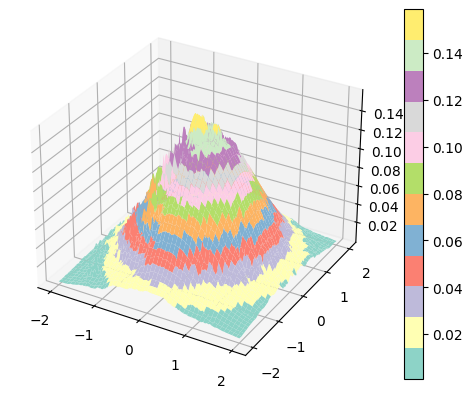

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate the NDVI values
ndvi = (nir - red) / (nir + red)

# Define the parameters for the Gaussian bell function
x = 0 # center point
y = 0  # center point
sigma_xy = 1  # spread in the xy plane
sigma_z = 1  # spread in the z direction
Qm =1  # maximum value of the bell function

# Create a meshgrid for the x, y, and NDVI values
xf, yf = np.meshgrid(np.linspace(-2, 2, red.shape[1]), np.linspace(-2, 2, red.shape[0]))
ndvif = np.meshgrid(np.linspace(-1, 1, red.shape[1]), np.linspace(-1, 1, red.shape[0]))[0]

# Create the 3D Gaussian bell function based on the NDVI values
f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))

# Plot the 3D Gaussian bell function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mappable = plt.cm.ScalarMappable(cmap=cmap)
mappable.set_array(f)
cbar = plt.colorbar(mappable)
ax.plot_surface(xf, yf, f, cmap=cmap)
plt.show()


----------


ABRIL 19 
SUPERFICIE

In [ ]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon, mapping, Point
import numpy as np

with rasterio.open('./img/3. IMG_700101_000458_0092_RED.TIF') as src:
    red = src.read(1)

    with rasterio.open('./img/2. IMG_700101_000458_0092_NIR.TIF') as src_nir:
        nir = src_nir.read(1)

    ndvi = (nir-red)/(nir+red)

    # Load the shape of the oil palm treetop
    # For example, if you have a shapefile called "oilpalm.shp", you can use the following code to load it:
    # oilpalm = gpd.read_file('oilpalm.shp')
    oilpalm_shape = Polygon([(250, 150), (300, 100), (400, 150), (350, 200)])

    # Clip the NDVI image to remove any non-vegetation areas
    masked_ndvi, _ = mask(src, [mapping(oilpalm_shape)], crop=True)

    # Create a new numpy array with the same shape as the NDVI image
    ndvi_veg = np.zeros(masked_ndvi.shape, dtype=np.float32)

    # For each pixel in the NDVI image, calculate the distance between the pixel and the nearest edge of the oil palm treetop shape
    for i in range(masked_ndvi.shape[0]):
        for j in range(masked_ndvi.shape[1]):
            if np.any(masked_ndvi[i,j] != 0): 
                # calculate the Euclidean distance between the pixel and the nearest edge of the shape
                distance = np.sqrt(oilpalm_shape.distance(Point(j,i)) ** 2)
                # Calculate the NDVI vegetation index using the formula `(NDVI + distance) / 2`
                ndvi_veg[i,j] = (masked_ndvi[i,j] + distance) / 2

    # Save the resulting image as a new GeoTIFF file
    with rasterio.open('ndvi_veg.tif', 'w', **src.profile) as dst:
        dst.write(ndvi_veg.squeeze(), 1)


------------------------

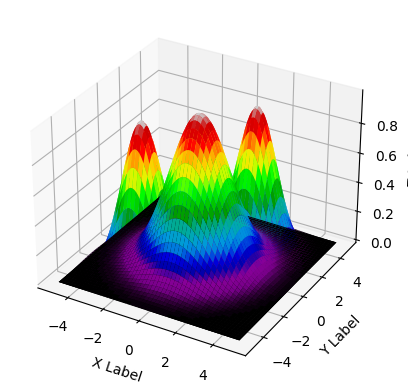

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# First bell
Z1 = gaussian(X, -2, 1) * gaussian(Y, -2, 1)
ax.plot_surface(X, Y, Z1, cmap=cmap, alpha=1)

# Second bell
Z2 = gaussian(X, 2, 1) * gaussian(Y, 2, 1)
ax.plot_surface(X, Y, Z2, cmap=cmap, alpha=1)

# Third bell
Z3 = gaussian(X, 0, 1.5) * gaussian(Y, 0, 1.5)
ax.plot_surface(X, Y, Z3, cmap=cmap, alpha=1)

ax.set_xlabel('X Label') 
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# First bell
Z1 = gaussian(X, -2, 1) * gaussian(Y, -2, 1)
ax.plot_surface(X, Y, Z1, cmap=cmap, alpha=1)

# Second bell
Z2 = gaussian(X, 2, 1) * gaussian(Y, 2, 1)
ax.plot_surface(X, Y, Z2, cmap=cmap, alpha=0.5)

# Third bell
Z3 = gaussian(X, 0, 1.5) * gaussian(Y, 0, 1.5)
ax.plot_surface(X, Y, Z3, cmap=cmap, alpha=0.5)

ax.set_xlabel('X Label') 
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for the x, y, and NDVI values
xf, yf = np.meshgrid(np.linspace(-10, 10, red.shape[1]), np.linspace(-10, 10, red.shape[0]))
ndvif = np.meshgrid(np.linspace(-1, 1, red.shape[1]), np.linspace(-1, 1, red.shape[0]))[0]

def calculate_ndvi(red, nir):
    #Calculate the NDVI values
    ndvi = (nir - red) / (nir + red)
    return(ndvi)

def gaussian_with_image(Qm, x, y, sigma_xy, sigma_z, ndvi, ndvif, xf, yf):
    # Create the 3D Gaussian bell function based on the NDVI values
    f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))
    return f

def plot_gaussian(f, xf, yf):
    # Plot the 3D Gaussian bell function
    ax.plot_surface(xf, yf, f, cmap=cmap)


<img src="https://www.mdpi.com/sustainability/sustainability-14-06668/article_deploy/html/images/sustainability-14-06668-g006-550.jpg">

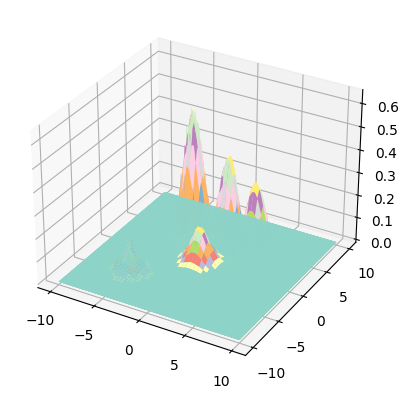

In [ ]:
cmap = 'Set3'

ndvi = calculate_ndvi(red, nir)
f = gaussian_with_image(1, 0, 0, 1, 1, ndvi, ndvif, xf, yf)
f2 = gaussian_with_image(2, 4, 4, 1,1,ndvi,ndvif,xf,yf)
f3 = gaussian_with_image(3, 2, 2, 1,1,ndvi,ndvif,xf,yf)
f4 = gaussian_with_image(5, -2, 2, 1,1,ndvi,ndvif,xf,yf)
f5 = gaussian_with_image(1, -5, -5, 1,1,ndvi,ndvif,xf,yf)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xf, yf, f2, cmap=cmap, alpha=1)
ax.plot_surface(xf, yf, f3, cmap=cmap, alpha=1)
ax.plot_surface(xf, yf, f4, cmap=cmap, alpha=1)
ax.plot_surface(xf, yf, f5, cmap=cmap, alpha=1)
ax.plot_surface(xf, yf, f, cmap=cmap, alpha=1)

plt.show()

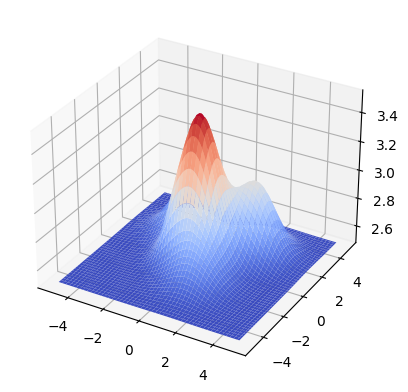

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the size of the grid
x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
z = np.zeros_like(x)

# Define the parameters for each Gaussian bell
params = [
    (1, 0, 0, 1, 1, 0.5),
    (0.5, 2, 2, 1, 1, 0.5),
    (0.3, -2, 2, 1, 1, 0.5),
    (0.2, 1, -2, 1, 1, 0.5),
    (0.1, -1, -1, 0.5, 0.5, 0.5)
]

# Calculate the value of the Gaussian bell for each point in the grid
for a, b, c, d, e, f in params:
    z += a * np.exp(-((x-b)**2/(2*d**2) + (y-c)**2/(2*e**2))) + f

# Plot the 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='coolwarm')
plt.show()
